## Data Processing and Modeling

In [697]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve
import json
import pickle
import joblib
import os



### Section 1: Data Processing

#### 0. Read and overview dataset

In [698]:
df = pd.read_csv("../Data/earthquake_tsunami_raw_data.csv")
# check base info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1758 non-null   object 
 1   magnitude  1758 non-null   float64
 2   cdi        1336 non-null   float64
 3   mmi        1756 non-null   float64
 4   sig        1758 non-null   int64  
 5   nst        543 non-null    float64
 6   dmin       1654 non-null   float64
 7   gap        1737 non-null   float64
 8   depth      1758 non-null   float64
 9   latitude   1758 non-null   float64
 10  longitude  1758 non-null   float64
 11  year       1758 non-null   int64  
 12  month      1758 non-null   int64  
 13  tsunami    1758 non-null   int64  
 14  place      1756 non-null   object 
 15  alert      1751 non-null   object 
 16  magType    1758 non-null   object 
 17  rms        1756 non-null   float64
 18  code       1758 non-null   object 
 19  net        1758 non-null   object 
 20  type    

In [699]:
# check unique values
for col in df.columns:
    n_unique = df[col].nunique()
    print(f"{col:20s}: {n_unique:6d} unique values")

title               :   1584 unique values
magnitude           :     27 unique values
cdi                 :     71 unique values
mmi                 :   1263 unique values
sig                 :    443 unique values
nst                 :    286 unique values
dmin                :   1455 unique values
gap                 :    158 unique values
depth               :    590 unique values
latitude            :   1758 unique values
longitude           :   1754 unique values
year                :     13 unique values
month               :     12 unique values
tsunami             :      2 unique values
place               :   1366 unique values
alert               :      4 unique values
magType             :      7 unique values
rms                 :    130 unique values
code                :   1758 unique values
net                 :      7 unique values
type                :      2 unique values
status              :      1 unique values
datetime            :   1758 unique values


In [700]:
missing_count = df.isnull().sum()
missing_ratio = df.isnull().mean() * 100
missing_table = pd.DataFrame({
    'missing_count': missing_count,
    'missing_ratio_%': missing_ratio
})
print(missing_table)

           missing_count  missing_ratio_%
title                  0         0.000000
magnitude              0         0.000000
cdi                  422        24.004551
mmi                    2         0.113766
sig                    0         0.000000
nst                 1215        69.112628
dmin                 104         5.915813
gap                   21         1.194539
depth                  0         0.000000
latitude               0         0.000000
longitude              0         0.000000
year                   0         0.000000
month                  0         0.000000
tsunami                0         0.000000
place                  2         0.113766
alert                  7         0.398180
magType                0         0.000000
rms                    2         0.113766
code                   0         0.000000
net                    0         0.000000
type                   0         0.000000
status                 0         0.000000
datetime               0         0

#### 1. Data cleaning <br>

a. Drop records with non-earthquake records

In [701]:
df['type'].unique()

array(['earthquake', 'nuclear explosion'], dtype=object)

In [702]:
df = df[df['type'] == 'earthquake']
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1757 entries, 0 to 1757
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      1757 non-null   object 
 1   magnitude  1757 non-null   float64
 2   cdi        1335 non-null   float64
 3   mmi        1755 non-null   float64
 4   sig        1757 non-null   int64  
 5   nst        543 non-null    float64
 6   dmin       1653 non-null   float64
 7   gap        1736 non-null   float64
 8   depth      1757 non-null   float64
 9   latitude   1757 non-null   float64
 10  longitude  1757 non-null   float64
 11  year       1757 non-null   int64  
 12  month      1757 non-null   int64  
 13  tsunami    1757 non-null   int64  
 14  place      1755 non-null   object 
 15  alert      1750 non-null   object 
 16  magType    1757 non-null   object 
 17  rms        1755 non-null   float64
 18  code       1757 non-null   object 
 19  net        1757 non-null   object 
 20  type       17

In [703]:
df['type'].unique()

array(['earthquake'], dtype=object)

b. Drop columns that are not needed for the analysis. The columns are:
- `title`: Combination of 'magnitude' and 'place' information, provides no additional predictive value.
- `code`: Event identifier code with no predictive value for tsunami occurrence.
- `status`: Review status indicator - metadata unrelated to earthquake physics or tsunami prediction.
- `net`: Data contributor network ID, not relevant for predictive modeling.
- `type`: Event type classification - all records are "earthquake", no variance.

c. Drop features that are duplicated with other features. The redundant columns are:
- `place`: Text description of location, duplicates geographic information already captured by 'latitude' and 'longitude' coordinates.
- `datetime`: Already split into 'Year' and 'Month' features, making the original column redundant.

d. Drop columns that are **post-event indicators** which are highly correlated with magnitude.
- `cdi`: The Community Determined Intensity (CDI) is an intensity value derived from public reports after an earthquake has occurred.
- `mmi`:  MMI is evaluated after an earthquake to measure the earthquake intensity and severity, which refer to the effects actually experienced at that place.
- `sig`: A number describing how significant the event is. Larger numbers indicate a more significant event. This value is determined on a number of factors, including: magnitude, maximum MMI, felt reports, and estimated impact.
- `alert`: Alert level generated after the event occurs, causing data leakage. Highly correlated with 'magnitude'. Additionally, contains 60% missing values.

e. Drop less necessary columns with 60% missing values
- `nst`：The total number of seismic stations used to determine earthquake location, which theoretically reflects earthquake detection coverage. It has a high missing rate, 69% missing.

In [704]:
drop_cols = ['title', 'place', 'alert', 'datetime', 'code', 'status', 'net', 'type', 'cdi', 'mmi', 'sig', 'nst']
df_cleaned = df.drop(columns=drop_cols)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1757 entries, 0 to 1757
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1757 non-null   float64
 1   dmin       1653 non-null   float64
 2   gap        1736 non-null   float64
 3   depth      1757 non-null   float64
 4   latitude   1757 non-null   float64
 5   longitude  1757 non-null   float64
 6   year       1757 non-null   int64  
 7   month      1757 non-null   int64  
 8   tsunami    1757 non-null   int64  
 9   magType    1757 non-null   object 
 10  rms        1755 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 164.7+ KB


#### 2. Imputing missing values

In [705]:
# check missing values
print(df_cleaned.isnull().sum())

magnitude      0
dmin         104
gap           21
depth          0
latitude       0
longitude      0
year           0
month          0
tsunami        0
magType        0
rms            2
dtype: int64


Impute the NaN values with the median value of the column. <br>


In [706]:
# compute all colunms' medians
def compute_and_save_medians(df: pd.DataFrame,
                             target_col: str = 'tsunami',
                             save_path: str = '../Model/column_medians.json') -> dict:
    median_dict = {}

    # obtain all numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    for col in numeric_cols:
        median_val = df[col].median()
        median_dict[col] = float(median_val)  # transfer to float
        print(f"{col}: {median_val:.4f}")

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # save as json
    with open(save_path, 'w') as f:
        json.dump(median_dict, f, indent=4)


    return median_dict

all_medians = compute_and_save_medians(df_cleaned)

magnitude: 6.2000
dmin: 2.2830
gap: 26.0000
depth: 20.0000
latitude: -5.2952
longitude: 100.4383
year: 2019.0000
month: 7.0000
rms: 0.8700


In [707]:
# impute
def impute_with_median(df: pd.DataFrame,
                       target_cols: list) -> pd.DataFrame:

    df = df.copy()

    for col in target_cols:
        if col not in df.columns:
            print(f"'{col}' not in DataFrame")
            continue

        # impute with median
        median_val = df[col].median()

        df[col] = df[col].fillna(median_val)
    return df

# `dmin`, `gap` , `rms` used to evaluate data quality, filling with its median.
quality_cols = ['dmin', 'gap', 'rms']

df_imputed = impute_with_median(df_cleaned, quality_cols)

print(df_imputed.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1757 entries, 0 to 1757
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1757 non-null   float64
 1   dmin       1757 non-null   float64
 2   gap        1757 non-null   float64
 3   depth      1757 non-null   float64
 4   latitude   1757 non-null   float64
 5   longitude  1757 non-null   float64
 6   year       1757 non-null   int64  
 7   month      1757 non-null   int64  
 8   tsunami    1757 non-null   int64  
 9   magType    1757 non-null   object 
 10  rms        1757 non-null   float64
dtypes: float64(7), int64(3), object(1)
memory usage: 164.7+ KB
None


#### 3. Feature Engineering

a. `latitude` and `longitude` are converted to 3D cartesian coordinates <br>

- Convert latitude/longitude to Cartesian coordinates (X, Y, Z) to handle
longitude periodicity (180° and -180° are adjacent) and enable proper
distance calculation for ML models. This transformation preserves geographic
relationships on Earth's spherical surface.


In [708]:
def convert_to_cartesian(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts latitude and longitude (in degrees) to 3D Cartesian coordinates (X, Y, Z).
    The formulas are:
    X = cos(lat) * cos(lon)
    Y = cos(lat) * sin(lon)
    Z = sin(lat)
    """
    df = df.copy()

    # Convert degrees to radians for trigonometric functions
    lat_rad = np.radians(df['latitude'])
    lon_rad = np.radians(df['longitude'])

    # Apply conversion formulas
    df['X'] = np.cos(lat_rad) * np.cos(lon_rad)
    df['Y'] = np.cos(lat_rad) * np.sin(lon_rad)
    df['Z'] = np.sin(lat_rad)

    return df

df_converted_1 = convert_to_cartesian(df_imputed)

print(df_converted_1[['latitude', 'longitude', 'X', 'Y', 'Z']].head())

   latitude  longitude         X         Y         Z
0   -6.7001   129.9887 -0.638248  0.760939 -0.116672
1   39.1959    28.2468  0.682702  0.366780  0.631974
2   16.5417   -59.5342  0.486040 -0.826259  0.284713
3   16.5416   -59.5832  0.485333 -0.826675  0.284711
4   -8.8524   123.9887 -0.552370  0.819271 -0.153890


b. Cyclical encoding for `month`
Month is a cyclical feature: December (12) and January (1) are actually adjacent in time, but numerically they appear far apart (12 vs 1).

In [709]:
def convert_month_to_cyclical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts month (1–12) into cyclical features using sine and cosine transforms:
    month_sin = sin(2π * month / 12)
    month_cos = cos(2π * month / 12)
    """
    df = df.copy()

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    return df

df_converted_2 = convert_month_to_cyclical(df_converted_1)

print(df_converted_2[['month', 'month_sin', 'month_cos']].head())

   month  month_sin  month_cos
0     10  -0.866025        0.5
1     10  -0.866025        0.5
2     10  -0.866025        0.5
3     10  -0.866025        0.5
4     10  -0.866025        0.5


c. One-Hot Encoding categorical variables `magType`

In [710]:
# check magType categories
print(df_converted_2['magType'].value_counts())

magType
mww    1679
mb       29
mw       20
mwb      18
mwc       6
ml        3
mwr       2
Name: count, dtype: int64


In [711]:
# use one-hot encoder to encode `magType`
def apply_one_hot_encoding(df: pd.DataFrame,
                           target_cols: list,
                           encoder=None,
                           fit: bool = True,
                           save_path: str = None) -> tuple:

    df = df.copy()

    if encoder is None:
        encoder = OneHotEncoder(
            sparse_output=False,
            handle_unknown='ignore',
            dtype=int
        )

    if fit:
        # training：fit encoder
        encoded_array = encoder.fit_transform(df[target_cols])
    else:
        # deploy：transform
        encoded_array = encoder.transform(df[target_cols])

    # get feature name
    feature_names = encoder.get_feature_names_out(target_cols)

    # drop original columns
    df_encoded = df.drop(columns=target_cols)

    # add encoded columns
    for idx, fname in enumerate(feature_names):
        df_encoded[fname] = encoded_array[:, idx]

    # save encoder
    if save_path and fit:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        joblib.dump(encoder, save_path)

        # save configs
        config = {
            'feature_names': list(feature_names),
            'categories': [list(cat) for cat in encoder.categories_],
            'target_cols': target_cols
        }
        config_path = save_path.replace('.pkl', '_config.json')
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=4)

        print(f"Encoder saved to: {save_path}")
        print(f"Config saved to: {config_path}")

    return df_encoded, encoder


df_ohe, ohe_encoder = apply_one_hot_encoding(
    df=df_converted_2,
    target_cols=['magType'],
    fit=True,
    save_path='../Model/onehot_encoder.pkl'
)

print(df_ohe.head())
print(f"\nEncoded columns: {[col for col in df_ohe.columns if 'magType' in col]}")


Encoder saved to: ../Model/onehot_encoder.pkl
Config saved to: ../Model/onehot_encoder_config.json
   magnitude   dmin   gap  depth  latitude  longitude  year  month  tsunami  \
0        6.4  2.165  16.0  142.0   -6.7001   129.9887  2025     10        0   
1        6.0  1.051  21.0    8.0   39.1959    28.2468  2025     10        0   
2        6.0  1.478  28.0   10.0   16.5417   -59.5342  2025     10        0   
3        6.5  1.432  21.0    9.0   16.5416   -59.5832  2025     10        1   
4        6.2  0.938  20.0   75.0   -8.8524   123.9887  2025     10        0   

    rms  ...         Z  month_sin  month_cos  magType_mb  magType_ml  \
0  0.67  ... -0.116672  -0.866025        0.5           0           0   
1  0.60  ...  0.631974  -0.866025        0.5           0           0   
2  0.70  ...  0.284713  -0.866025        0.5           1           0   
3  0.73  ...  0.284711  -0.866025        0.5           0           0   
4  0.93  ... -0.153890  -0.866025        0.5           0          

### Section 2: Splitting and scaling for training

#### 1. Define target dataset and feature datasets

Drop original columns that have been transformed into engineered features.

In [712]:
print(df_ohe.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1757 entries, 0 to 1757
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   magnitude    1757 non-null   float64
 1   dmin         1757 non-null   float64
 2   gap          1757 non-null   float64
 3   depth        1757 non-null   float64
 4   latitude     1757 non-null   float64
 5   longitude    1757 non-null   float64
 6   year         1757 non-null   int64  
 7   month        1757 non-null   int64  
 8   tsunami      1757 non-null   int64  
 9   rms          1757 non-null   float64
 10  X            1757 non-null   float64
 11  Y            1757 non-null   float64
 12  Z            1757 non-null   float64
 13  month_sin    1757 non-null   float64
 14  month_cos    1757 non-null   float64
 15  magType_mb   1757 non-null   int64  
 16  magType_ml   1757 non-null   int64  
 17  magType_mw   1757 non-null   int64  
 18  magType_mwb  1757 non-null   int64  
 19  magType_mwc

In [713]:
# Drop duplicate columns which has been transformed into engineered features, and target column.
X = df_ohe.drop(columns=['tsunami', 'latitude', 'longitude', 'month'])
y = df_ohe['tsunami']

print(X.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1757 entries, 0 to 1757
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   magnitude    1757 non-null   float64
 1   dmin         1757 non-null   float64
 2   gap          1757 non-null   float64
 3   depth        1757 non-null   float64
 4   year         1757 non-null   int64  
 5   rms          1757 non-null   float64
 6   X            1757 non-null   float64
 7   Y            1757 non-null   float64
 8   Z            1757 non-null   float64
 9   month_sin    1757 non-null   float64
 10  month_cos    1757 non-null   float64
 11  magType_mb   1757 non-null   int64  
 12  magType_ml   1757 non-null   int64  
 13  magType_mw   1757 non-null   int64  
 14  magType_mwb  1757 non-null   int64  
 15  magType_mwc  1757 non-null   int64  
 16  magType_mwr  1757 non-null   int64  
 17  magType_mww  1757 non-null   int64  
dtypes: float64(10), int64(8)
memory usage: 260.8 KB
None


#### 2. Train-test split

In [714]:
class_counts = pd.Series(y).value_counts().sort_index()
imbalance_ratio = class_counts[0] / class_counts[1]

print(f"Class 0 (Non-Tsunami): {class_counts[0]}")
print(f"Class 1 (Tsunami): {class_counts[1]}")
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")

Class 0 (Non-Tsunami): 1173
Class 1 (Tsunami): 584
Imbalance Ratio: 2.01:1


In [715]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

tsunami
0    0.667616
1    0.332384
Name: proportion, dtype: float64
tsunami
0    0.667614
1    0.332386
Name: proportion, dtype: float64


#### 3. Feature scaling

In [716]:
def scale_train_test(X_train, X_test, exclude_cols=None, save_scaler=True, scaler_path='../Model/scaler.pkl'):
    """
    fit scaler for train data，and transform train + test
    """
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    if exclude_cols is None:
        exclude_cols = []

    numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()
    scaling_cols = [col for col in numerical_cols if col not in exclude_cols]

    scaler = StandardScaler()
    scaler.fit(X_train[scaling_cols])

    X_train_scaled[scaling_cols] = scaler.transform(X_train[scaling_cols])
    X_test_scaled[scaling_cols] = scaler.transform(X_test[scaling_cols])

    # save scaler for deployment
    if save_scaler:
        # save scaler
        joblib.dump(scaler, scaler_path)

        # save config info（scaling_cols + exclude_cols）
        scaler_config = {
            'scaling_cols': scaling_cols,
            'exclude_cols': exclude_cols,
            'feature_names': list(X_train.columns)
        }

        config_path = scaler_path.replace('.pkl', '_config.json')
        with open(config_path, 'w') as f:
            json.dump(scaler_config, f, indent=4)

        print(f"Scaler saved to: {scaler_path}")
        print(f"Config saved to: {config_path}")

    return X_train_scaled, X_test_scaled, scaler


# scale features except one-hot encoded columns
exclude_cols = [col for col in X_train.columns if 'magType_' in col]

X_train_scaled, X_test_scaled, trained_scaler = scale_train_test(
    X_train, X_test,
    exclude_cols=exclude_cols,
    save_scaler=True,
    scaler_path='../Model/scaler.pkl'
)


Scaler saved to: ../Model/scaler.pkl
Config saved to: ../Model/scaler_config.json


### Section 3: Model Training (Baseline Model) & Performance Check

#### 1. Decision Tree

In [717]:
dt = DecisionTreeClassifier(
    random_state=42
)

dt.fit(X_train_scaled, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [718]:
y_pred_dt = dt.predict(X_test_scaled)
y_prob_dt = dt.predict_proba(X_test_scaled)[:, 1]

print("Classification Report for Decision Tree:\n")
print(classification_report(y_test, y_pred_dt))
print('-'*80)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       235
           1       0.76      0.85      0.80       117

    accuracy                           0.86       352
   macro avg       0.84      0.86      0.85       352
weighted avg       0.87      0.86      0.86       352

--------------------------------------------------------------------------------
Confusion Matrix:
 [[203  32]
 [ 17 100]]


#### 2. Random Forest

In [719]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf.fit(X_train_scaled, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [720]:
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("Classification Report for Random Forest:\n")
print(classification_report(y_test, y_pred_rf))
print('-'*80)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       235
           1       0.86      0.85      0.86       117

    accuracy                           0.91       352
   macro avg       0.90      0.89      0.89       352
weighted avg       0.91      0.91      0.91       352

--------------------------------------------------------------------------------
Confusion Matrix:
 [[219  16]
 [ 17 100]]


#### 3. K-Nearest Neighbors

In [721]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [722]:
y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]

print("Classification Report for KNN:\n")
print(classification_report(y_test, y_pred_knn))
print('-'*80)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       235
           1       0.77      0.65      0.70       117

    accuracy                           0.82       352
   macro avg       0.80      0.78      0.79       352
weighted avg       0.81      0.82      0.81       352

--------------------------------------------------------------------------------
Confusion Matrix:
 [[212  23]
 [ 41  76]]


#### 4. XGBoost

In [723]:
xgb = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train_scaled, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [724]:
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

print("Classification Report for XGBoost:\n")
print(classification_report(y_test, y_pred_xgb))
print('-'*80)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       235
           1       0.82      0.83      0.83       117

    accuracy                           0.88       352
   macro avg       0.87      0.87      0.87       352
weighted avg       0.88      0.88      0.88       352

--------------------------------------------------------------------------------
Confusion Matrix:
 [[214  21]
 [ 20  97]]


#### 5. Logic Regression

In [725]:
lr = LogisticRegression(
    random_state=42
)

lr.fit(X_train_scaled, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [726]:
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Classification Report for Logistic Regression:\n")
print(classification_report(y_test, y_pred_lr))
print('-'*80)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       235
           1       0.82      0.65      0.72       117

    accuracy                           0.84       352
   macro avg       0.83      0.79      0.80       352
weighted avg       0.83      0.84      0.83       352

--------------------------------------------------------------------------------
Confusion Matrix:
 [[218  17]
 [ 41  76]]


### Section 4: Hyperparameter Tuning

#### 1. Check All models' performance

<div style="color:#2874A6">

**Explanation**:<br>

The goal of this baseline evaluation is to select the better models for hyperparameter tuning. <br>

Because this project predicts whether an earthquake will generate a tsunami (Class 1), we mainly focus on the metrics of Class 1. <br>

Class 1 errors have CRITICAL consequences:
- False Negative (FN): Missed tsunami
- False Positive (FP): False alarm

</div>

Model,Accuracy,Precision_Class1,Recall_Class1,F1_Class1,ROC-AUC
Random Forest,0.906,0.862,0.855,0.858,0.933
XGBoost,0.884,0.822,0.829,0.826,0.930
Decision Tree,0.861,0.758,0.855,0.803,0.859
Logistic Regression,0.835,0.817,0.650,0.724,0.900
KNN,0.818,0.768,0.650,0.704,0.871


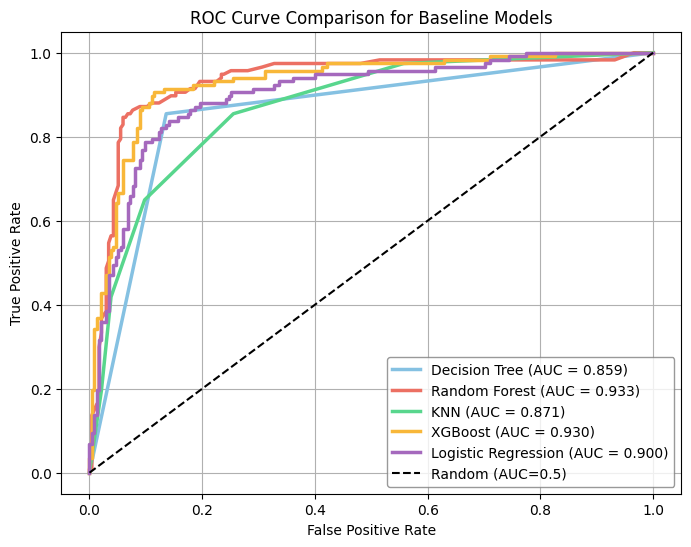

In [727]:
# collect predictions & probabilities
predictions = {
    "Decision Tree": (y_pred_dt, y_prob_dt),
    "Random Forest": (y_pred_rf, y_prob_rf),
    "KNN": (y_pred_knn, y_prob_knn),
    "XGBoost": (y_pred_xgb, y_prob_xgb),
    "Logistic Regression": (y_pred_lr, y_prob_lr)
}

# compute metrics
results_base = []

for name, (y_pred, y_prob) in predictions.items():
    results_base.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision_Class1": precision_score(y_test, y_pred, pos_label=1),
        "Recall_Class1": recall_score(y_test, y_pred, pos_label=1),
        "F1_Class1": f1_score(y_test, y_pred, pos_label=1),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })
# convert to DataFrame
df_results_base = pd.DataFrame(results_base)

# Sort by F1_Class1 for easy comparison
df_results_base = df_results_base.sort_values(by="F1_Class1", ascending=False).reset_index(drop=True)

# metrics form
metric_cols = ['Accuracy', 'Precision_Class1', 'Recall_Class1', 'F1_Class1', 'ROC-AUC']
styled = df_results_base.style \
    .set_caption("Baseline Model Comparison for Class 1 Metrics") \
    .format("{:.3f}", subset=metric_cols) \
    .hide(axis="index") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('background-color', '#3E7B5F'), ('color', 'white'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '12px')]},
        {'selector': 'td:first-child', 'props': [('font-weight', 'bold')]}
    ]) \
    .highlight_max(subset=metric_cols, color='#C8E6C9')

display(styled)
print('='*80)
print()

# ROC Curves
plt.figure(figsize=(8, 6))
colors = ['#85C1E2','#EC7063','#58D68D','#F8B739','#A569BD']
for idx, (name, (y_pred, y_prob)) in enumerate(predictions.items()):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2.5, color=colors[idx], label=f"{name} (AUC = {roc_auc:.3f})")

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Baseline Models")
plt.legend(loc="lower right", fontsize=10, frameon=True, edgecolor="gray")
plt.grid(True)
plt.show()

<div style="color:#2874A6">

**Observation**:<br>
- Random Forest and XGBoost Baseline Models are top performers.
    - Random Forest has the highest F1 Score (0.858), Recall (0.855), and ROC-AUC (0.933), meaning it captures the most true tsunami events while maintaining excellent discriminative ability.
    - XGBoost demonstrates strong overall performance with the high Accuracy (0.884) and balanced Precision (0.822) and Recall (0.829), resulting in a competitive F1 Score (0.826) and strong ROC-AUC (0.930).
    - Both Random Forest and XGBoost models also show strong ROC-AUC values (>0.93), indicating excellent ability to distinguish between tsunami and non-tsunami events.
- Decision Tree shows moderate performance with an F1 Score of 0.795 even though it has a high Recall of 0.855, but its ROC-AUC (0.859) is notably lower than the other methods, suggesting limited discriminative power.
- Logistic Regression and KNN demonstrate weaker performance on Class 1 metrics.
    - Logistic Regression achieves reasonable ROC-AUC (0.900) but suffers from low Recall (0.650), resulting in a poor F1 Score (0.724). This indicates it misses a significant number of tsunami events.
    - KNN shows the poorest overall performance with the lowest Recall (0.650), F1 Score (0.704), and ROC-AUC (0.871), making it unsuitable for this critical prediction task.
- Tsunami prediction requires capturing complex, non-linear feature interactions.

**Summary**: <br>
- **XGBoost** and **Random Forest** are selected for hyperparameter tuning due to their better performance in identifying tsunami events.

</div>

#### 2. Hyperparameter Tuning for Random  Forest

<div style="color:#2874A6">

**Explanation**:<br>

Hyperparameter tuning is essential for improving model performance, especially for complex models such as Random Forest and XGBoost. We used Optuna to help us find the best hyperparameters for our model efficiently.


</div>

- n_estimators: Number of trees in the forest
- max_depth: Maximum depth of each tree (controls complexity)
- min_samples_split: Minimum samples required to split a node (prevents overfitting)
- min_samples_leaf: Minimum samples required in leaf nodes (regularization)
- max_features: Number of features to consider per split (adds randomness)

In [728]:
# Optuna algorithm for tuning
# Objective function
def rf_objective(trial):
    # Define hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 5, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 5, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "random_state": 42
    }

    # create model
    model_rf = RandomForestClassifier(**params)

    # 5-fold cross-validation F1 score
    score = cross_val_score(model_rf, X_train_scaled, y_train, cv=5, scoring='f1').mean()
    return score

# Run Optuna study and optimize
rf_study = optuna.create_study(direction="maximize", study_name='RF_Tuning')
rf_study.optimize(rf_objective, n_trials=50)

[I 2025-11-23 22:35:55,472] A new study created in memory with name: RF_Tuning
[I 2025-11-23 22:35:56,658] Trial 0 finished with value: 0.7977681232145676 and parameters: {'n_estimators': 271, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7977681232145676.
[I 2025-11-23 22:35:58,986] Trial 1 finished with value: 0.7989731765313838 and parameters: {'n_estimators': 500, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7989731765313838.
[I 2025-11-23 22:35:59,570] Trial 2 finished with value: 0.7888711174624673 and parameters: {'n_estimators': 128, 'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 19, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7989731765313838.
[I 2025-11-23 22:36:02,085] Trial 3 finished with value: 0.808959439925955 and parameters: {'n_estimators': 503, 'max_depth': 22, 'min_samples_split': 16, 'min_sample

In [729]:
print("Best Random Forest parameters:", rf_study.best_params)
print("\nBest F1 score:", rf_study.best_value)

Best Random Forest parameters: {'n_estimators': 247, 'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}

Best F1 score: 0.8358618825819706


In [730]:
# Train final model on entire training set
rf_best = RandomForestClassifier(**rf_study.best_params)
rf_best.fit(X_train_scaled, y_train)
y_pred_rf_tuned = rf_best.predict(X_test_scaled)
y_prob_rf_tuned = rf_best.predict_proba(X_test_scaled)[:, 1]

print(f"Tuned RF - Accuracy: {accuracy_score(y_test, y_pred_rf_tuned):.3f}")
print(f"Tuned RF - F1 Score: {f1_score(y_test, y_pred_rf_tuned, pos_label=1):.3f}")
print(f"Tuned RF - Recall: {recall_score(y_test, y_pred_rf_tuned, pos_label=1):.3f}")
print(f"Tuned RF - ROC-AUC: {roc_auc_score(y_test, y_prob_rf_tuned):.3f}")
print('-'*60)
print(classification_report(y_test, y_pred_rf_tuned))


Tuned RF - Accuracy: 0.909
Tuned RF - F1 Score: 0.864
Tuned RF - Recall: 0.872
Tuned RF - ROC-AUC: 0.937
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       235
           1       0.86      0.87      0.86       117

    accuracy                           0.91       352
   macro avg       0.90      0.90      0.90       352
weighted avg       0.91      0.91      0.91       352



#### 3. Hyperparameter Tuning for XGBoost

- n_estimators: Number of boosting rounds
- max_depth: Maximum tree depth (controls complexity)
- learning_rate: Step size shrinkage (prevents overfitting)
- subsample: Fraction of samples per tree (adds randomness)
- colsample_bytree: Fraction of features per tree (reduces correlation)
- gamma: Minimum loss reduction to make a split (regularization)
- min_child_weight: Minimum weight needed in child nodes (prevents overfitting)

In [731]:
def xgb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 8),
        # "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),   # L1
        # "reg_lambda": trial.suggest_float("reg_lambda", 1.0, 5.0), # L2
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "random_state": 42
    }

    model_xgb = XGBClassifier(**params)
    score = cross_val_score(model_xgb, X_train_scaled, y_train, cv=5, scoring='f1').mean()
    return score

# Run Optuna study
xgb_study = optuna.create_study(direction="maximize", study_name='XGBoost_Tuning')
xgb_study.optimize(xgb_objective, n_trials=50)

[I 2025-11-23 22:38:28,148] A new study created in memory with name: XGBoost_Tuning
[I 2025-11-23 22:38:30,468] Trial 0 finished with value: 0.820068523532021 and parameters: {'n_estimators': 320, 'max_depth': 7, 'learning_rate': 0.023367226412327472, 'subsample': 0.9972928790876288, 'colsample_bytree': 0.8700127582218948, 'gamma': 6.600186358505832, 'min_child_weight': 3}. Best is trial 0 with value: 0.820068523532021.
[I 2025-11-23 22:38:31,842] Trial 1 finished with value: 0.8230141401578207 and parameters: {'n_estimators': 377, 'max_depth': 7, 'learning_rate': 0.0451875516518057, 'subsample': 0.810331787295573, 'colsample_bytree': 0.565928792737812, 'gamma': 5.503544088496545, 'min_child_weight': 8}. Best is trial 1 with value: 0.8230141401578207.
[I 2025-11-23 22:38:33,105] Trial 2 finished with value: 0.8235568769623189 and parameters: {'n_estimators': 484, 'max_depth': 11, 'learning_rate': 0.08081179702511193, 'subsample': 0.8202834208018515, 'colsample_bytree': 0.57505970408566

In [732]:
print("Best XGBoost parameters:", xgb_study.best_params)
print("Best F1 score:", xgb_study.best_value)

Best XGBoost parameters: {'n_estimators': 270, 'max_depth': 12, 'learning_rate': 0.095742170086362, 'subsample': 0.8621142065155597, 'colsample_bytree': 0.8376894813899407, 'gamma': 2.5638713099483805, 'min_child_weight': 5}
Best F1 score: 0.8407210014944821


In [733]:
# Train final model on entire training set
xgb_best = XGBClassifier(**xgb_study.best_params)
xgb_best.fit(X_train_scaled, y_train)
y_pred_xgb_tuned = xgb_best.predict(X_test_scaled)
y_prob_xgb_tuned = xgb_best.predict_proba(X_test_scaled)[:, 1]

print(f"\nTuned XGBoost - Accuracy: {accuracy_score(y_test, y_pred_xgb_tuned):.3f}")
print(f"Tuned XGBoost - Precision (Class 1): {precision_score(y_test, y_pred_xgb_tuned, pos_label=1):.3f}")
print(f"Tuned XGBoost - Recall (Class 1): {recall_score(y_test, y_pred_xgb_tuned, pos_label=1):.3f}")
print(f"Tuned XGBoost - F1 Score (Class 1): {f1_score(y_test, y_pred_xgb_tuned, pos_label=1):.3f}")
print(f"Tuned XGBoost - ROC-AUC: {roc_auc_score(y_test, y_prob_xgb_tuned):.3f}")
print('-'*60)
print(classification_report(y_test, y_pred_xgb_tuned))


Tuned XGBoost - Accuracy: 0.909
Tuned XGBoost - Precision (Class 1): 0.851
Tuned XGBoost - Recall (Class 1): 0.880
Tuned XGBoost - F1 Score (Class 1): 0.866
Tuned XGBoost - ROC-AUC: 0.943
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       235
           1       0.85      0.88      0.87       117

    accuracy                           0.91       352
   macro avg       0.90      0.90      0.90       352
weighted avg       0.91      0.91      0.91       352



#### 4. Model Performance Comparison: Baseline vs Tuned

In [734]:
models_evaluation = {
    "Random Forest (Baseline)": (y_pred_rf, y_prob_rf),
    "XGBoost (Baseline)": (y_pred_xgb, y_prob_xgb),
    "Random Forest (Tuned)": (y_pred_rf_tuned, y_prob_rf_tuned),
    "XGBoost (Tuned)": (y_pred_xgb_tuned, y_prob_xgb_tuned)
}


results_comparison = []

for name, (y_pred, y_prob) in models_evaluation.items():
    results_comparison.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision (Class 1)": precision_score(y_test, y_pred, pos_label=1),
        "Recall (Class 1)": recall_score(y_test, y_pred, pos_label=1),
        "F1 Score (Class 1)": f1_score(y_test, y_pred, pos_label=1),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

df_comparison = pd.DataFrame(results_comparison)
df_comparison = df_comparison.sort_values(by="F1 Score (Class 1)", ascending=False).reset_index(drop=True)

In [764]:
# Step 1: Extract F1 scores
baseline_xgb_f1 = df_comparison[df_comparison['Model'] == 'XGBoost (Baseline)']['F1 Score (Class 1)'].values[0]
baseline_rf_f1 = df_comparison[df_comparison['Model'] == 'Random Forest (Baseline)']['F1 Score (Class 1)'].values[0]
tuned_xgb_f1 = df_comparison[df_comparison['Model'] == 'XGBoost (Tuned)']['F1 Score (Class 1)'].values[0]
tuned_rf_f1 = df_comparison[df_comparison['Model'] == 'Random Forest (Tuned)']['F1 Score (Class 1)'].values[0]

# Step 2: Create comparison dictionary
f1_comparison = {
    'Model': ['XGBoost', 'Random Forest'],
    'Baseline F1': [baseline_xgb_f1, baseline_rf_f1],
    'Tuned F1': [tuned_xgb_f1, tuned_rf_f1]
}

# Step 3: Create DataFrame
df_f1 = pd.DataFrame(f1_comparison)

# Step 4: Calculate improvements
df_f1['Improvement (Δ)'] = df_f1['Tuned F1'] - df_f1['Baseline F1']
df_f1['Improvement (%)'] = (df_f1['Improvement (Δ)'] / df_f1['Baseline F1'] * 100)

# style form
styled_f1 = df_f1.style \
    .set_caption("F1 Score Improvement After Hyperparameter Tuning") \
    .format({
        'Baseline F1': "{:.3f}",
        'Tuned F1': "{:.3f}",
        'Improvement (Δ)': "{:+.3f}",
        'Improvement (%)': "{:+.1f}%"
    }) \
    .hide(axis="index") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold'),
                                          ('margin-bottom', '12px')]},
        {'selector': 'th', 'props': [('background-color', '#3E7B5F'), ('color', 'white'),
                                     ('text-align', 'center'), ('padding', '12px'),
                                     ('font-size', '11pt')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '10px'),
                                     ('font-size', '11pt')]},
        {'selector': 'td:first-child', 'props': [('font-weight', 'bold')]},
        {'selector': 'table', 'props': [('width', '80%'), ('margin', 'auto')]}
    ])

display(styled_f1)

Model,Baseline F1,Tuned F1,Improvement (Δ),Improvement (%)
XGBoost,0.826,0.866,+0.040,+4.8%
Random Forest,0.858,0.864,+0.006,+0.7%


<div style="color:#2874A6">

**Summary**:<br>
a. Use F1-Score (Class 1) for Hyperparameter Tuning:<br>
- F1 is calculated for the POSITIVE class (Class 1 = Tsunami)
   - Formula: F1 = 2 × (Precision × Recall) / (Precision + Recall)
     - Precision = TP / (TP + FP)  [How many prediced tsunamis are real?]
     - Recall = TP / (TP + FN)     [How many real tsunamis are detected?]
   - Both metrics focus on correctly identifying Class 1 (Tsunami events)

b. Tuning Result:<br>
   - After hyperparameter tuning, the both models have improved its F1 score for class 1 (the positive class). This indicates that the models are better at identifying positive instances (tsunami).

</div>

### Section 5. Model Evaluation and Best Model Selection

#### 1. Overall Model Performance

a. Performance Evaluation Metrics - Accuracy, Precision, Recall, F1-Score

In [750]:
models_evaluation_for_best = {
    "Random Forest": (y_pred_rf_tuned, y_prob_rf_tuned),
    "XGBoost": (y_pred_xgb_tuned, y_prob_xgb_tuned)
}

tuned_comparison = []

for name, (y_pred, y_prob) in models_evaluation_for_best.items():
    tuned_comparison.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision_Class1': precision_score(y_test, y_pred, pos_label=1),
        'Recall_Class1': recall_score(y_test, y_pred, pos_label=1),
        'F1_Class1': f1_score(y_test, y_pred, pos_label=1)
    })

df_tuned_comparison = pd.DataFrame(tuned_comparison)
df_tuned_comparison = df_tuned_comparison.sort_values(by="F1_Class1", ascending=False).reset_index(drop=True)


metric_cols = ['Accuracy', 'Precision_Class1', 'Recall_Class1', 'F1_Class1']

styled = df_tuned_comparison.style \
    .set_caption("Final Model Performance Comparison (Tuned Models)") \
    .format("{:.3f}", subset=metric_cols) \
    .hide(axis="index") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '14pt'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('background-color', '#3E7B5F'), ('color', 'white'), ('text-align', 'center'),  ('padding', '14px')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('padding', '14px')]},
        {'selector': 'td:first-child', 'props': [('font-weight', 'bold')]}
    ]) \
    .highlight_max(subset=metric_cols, color='#C8E6C9')

display(styled)

Model,Accuracy,Precision_Class1,Recall_Class1,F1_Class1
XGBoost,0.909,0.851,0.880,0.866
Random Forest,0.909,0.857,0.872,0.864


<div style="color:#2874A6">

**Observation**:<br>

Both tuned models demonstrate strong performance with minimal differences:<br>
   - Accuracy: Both achieve 90.9% <br>
   - F1-Score: XGBoost (0.866) slightly outperforms RF (0.864) by 0.2%

XGBoost shows superior tsunami detection capability while Random Forest performs better precision for positive predictions.

</div>

b. Confusion matrix

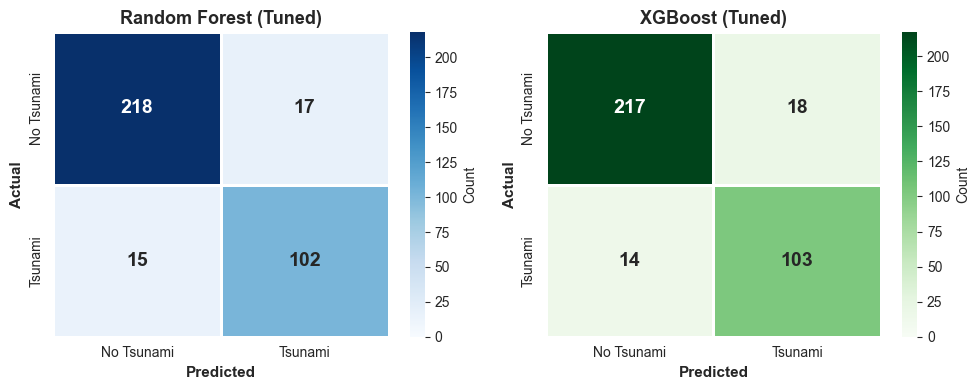


=== Error Rates ===

False Negative Rate (Missed Tsunamis):
  Random Forest: 12.8%
  XGBoost:       12.0%

False Positive Rate (False Alarms):
  Random Forest: 7.2%
  XGBoost:       7.7%


In [766]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Random Forest -
cm_rf = confusion_matrix(y_test, y_pred_rf_tuned)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=cm_rf.max(),
            xticklabels=['No Tsunami', 'Tsunami'],
            yticklabels=['No Tsunami', 'Tsunami'],
            linewidths=2, linecolor='white',
            annot_kws={'size': 14, 'weight': 'bold'},
            cbar_kws={'label': 'Count'},
            ax=axes[0])
axes[0].set_title('Random Forest (Tuned)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=11, fontweight='bold')

# XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb_tuned)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', vmin=0, vmax=cm_xgb.max(),
            xticklabels=['No Tsunami', 'Tsunami'],
            yticklabels=['No Tsunami', 'Tsunami'],
            linewidths=2, linecolor='white',
            annot_kws={'size': 14, 'weight': 'bold'},
            cbar_kws={'label': 'Count'},
            ax=axes[1])
axes[1].set_title('XGBoost (Tuned)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Print comparison
tn_rf, fp_rf, fn_rf, tp_rf = cm_rf.ravel()
tn_xgb, fp_xgb, fn_xgb, tp_xgb = cm_xgb.ravel()

print("\n=== Error Rates ===")
fn_rate_rf = fn_rf / (fn_rf + tp_rf) * 100
fn_rate_xgb = fn_xgb / (fn_xgb + tp_xgb) * 100
fp_rate_rf = fp_rf / (fp_rf + tn_rf) * 100
fp_rate_xgb = fp_xgb / (fp_xgb + tn_xgb) * 100

print(f"\nFalse Negative Rate (Missed Tsunamis):")
print(f"  Random Forest: {fn_rate_rf:.1f}%")
print(f"  XGBoost:       {fn_rate_xgb:.1f}%")

print(f"\nFalse Positive Rate (False Alarms):")
print(f"  Random Forest: {fp_rate_rf:.1f}%")
print(f"  XGBoost:       {fp_rate_xgb:.1f}%")

<div style="color:#2874A6">

True Negatives (TN)
   - Definition: Correctly predicted as "No Tsunami"
   - Meaning: Model correctly identified non-tsunami events

False Positives (FP)
   - Definition: Incorrectly predicted as "Tsunami"
   - Meaning: Model raised false alarm

False Negatives (FN)
   - Definition: Incorrectly predicted as "No Tsunami"
   - Meaning: Model MISSED a real tsunami
   - Example: Tsunami occurred, but model failed to predict it
   - In real world: THIS IS THE MOST DANGEROUS ERROR IN TSUNAMI PREDICTION

True Positives (TP)
   - Definition: Correctly predicted as "Tsunami"
   - Meaning: Model successfully detected tsunami

</div>

<div style="color:#2874A6">

Error Rates:
- False Negative Rate (Miss Rate) = FN / (FN + TP)
    - Random Forest Model missed 12.8% of real tsunamis, XGBoost missed 12%
- False Positive Rate (False Alarm Rate) = FP / (FP + TN)
    - Random Forest Model raised false alarms for 7.2% of non-tsunami events, XGBoost raised false alarms for 7.7%
</div>

c. ROC Curve

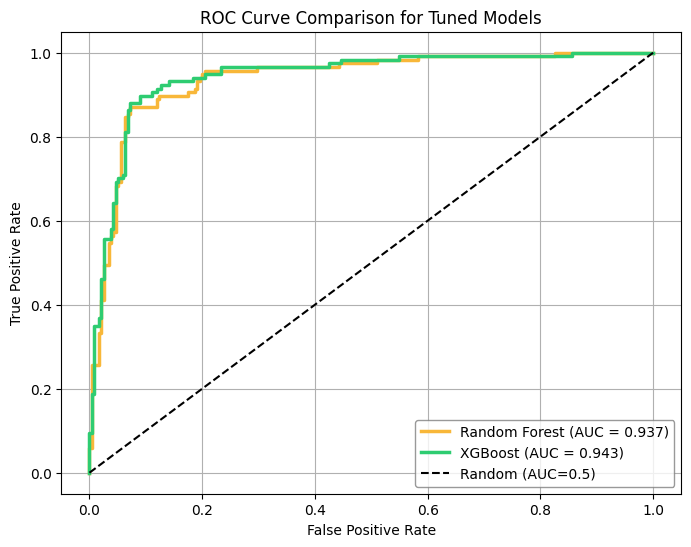

In [758]:
plt.figure(figsize=(8, 6))

colors = ['#F8B739', '#2ECC71']

# Plot ROC curve for each model
for idx, (name, (y_pred, y_prob)) in enumerate(models_evaluation_for_best.items()):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2.5, color=colors[idx], label=f"{name} (AUC = {roc_auc:.3f})")

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.5)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Tuned Models")
plt.legend(loc="lower right", fontsize=10, frameon=True, edgecolor="gray")
plt.grid(True)
plt.show()


<div style="color:#2874A6">

**Observation**:<br>
Two models' ROC–AUC scores are higher than 0.93, indicating that they have excellent discriminative ability. This means they can correctly differentiate between tsunami-generating and non-tsunami earthquakes about >93% of the time.

</div>

#### 2. Best Model - XGBoost

a. Why XGBoost?

<div style="color:#2874A6">


XGBoost Advantages:
- Higher Recall (+0.8%):     Detects more real tsunamis
- Higher F1 (+0.2%):         Better overall balance
- Higher ROC-AUC (+0.6%):    Superior discrimination ability
- Lower FN count (14 vs 15): 1 fewer missed tsunami

Random Forest Advantages:
- Higher Precision (+0.6%):  Fewer false alarms
- Lower FP count (17 vs 18): 1 fewer false alarm

From the realistic perspective, higher Recall is more important than Precision, because detecting real tsunamis is more critical than avoiding false alarms. Of course, high F1 score shows that the model has a good balance between Precision and Recall.

We select XGBoost as our best model because it has overall superior performance.
</div>

b. Save Best Model

In [759]:
# Create Model directory if not exists
os.makedirs('../Model', exist_ok=True)

# Save XGBoost model
joblib.dump(xgb_best, '../Model/best_model_xgboost.pkl')
print("Best model saved: ../Model/best_model_xgboost.pkl")

# Save model parameters and performance metrics
best_model_info = {
    'model_name': 'XGBoost Best Model',
    'hyperparameters': xgb_study.best_params,
    'test_performance': {
        'accuracy': float(accuracy_score(y_test, y_pred_xgb_tuned)),
        'precision_class1': float(precision_score(y_test, y_pred_xgb_tuned, pos_label=1)),
        'recall_class1': float(recall_score(y_test, y_pred_xgb_tuned, pos_label=1)),
        'f1_class1': float(f1_score(y_test, y_pred_xgb_tuned, pos_label=1)),
        'roc_auc': float(roc_auc_score(y_test, y_prob_xgb_tuned))
    }
}

with open('../Model/best_model_xgboost_info.json', 'w') as f:
    json.dump(best_model_info, f, indent=4)
print("Model info saved: ../Model/best_model_xgboost_info.json")

Best model saved: ../Model/best_model_xgboost.pkl
Model info saved: ../Model/best_model_xgboost_info.json
